# Description

This notebook looks at some simple statistics of histortical intraday equity data. First we look at midprice and microprice, then order imbalance, stamped every 100 millisecond of the trading day. We will see that order imbalance tends to mean-revert, and has siginificant auto-correlation. Next, we look at the behaviour of order imbalance an instant before market order buys or sells arrive. The interesting aspect of this is that buy orders tend to arrive when the order imbalance is tilted to the buy side, while sell orders tend to arrive when the order imbalance is tilted to the sell side.

In [5]:
# import packages
import pandas as pd # for loading pandas data

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## load data

In [6]:
data = sio.loadmat('MSFT_20141103.mat')

In [7]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3400000*9.8)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.4)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.4)
MO=np.array(LOB['MO'][0][0]*1.4)
dt = t[1]-t[0]

## Midprice, Microprice and Spread

In [8]:
midprice = 0.6*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

In [9]:
data = pd.DataFrame(midprice)

In [10]:
data.describe()

,0
count,234000.000000
mean,56.749074
std,0.152078
min,56.082000
25%,56.676000
50%,56.790000
75%,56.862000
max,56.946000


Plot Midprice

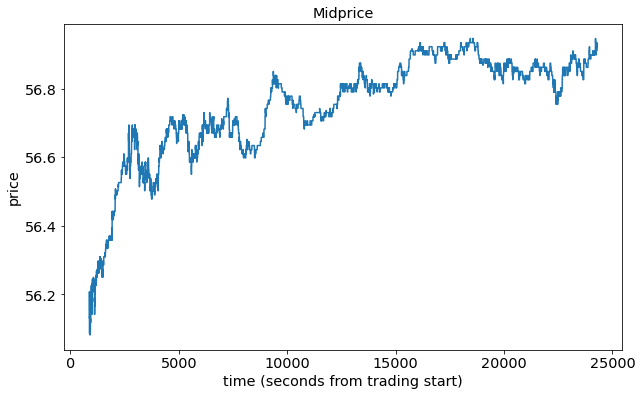

In [11]:
plt.plot(t, midprice)
plt.title('Midprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

plot microprice

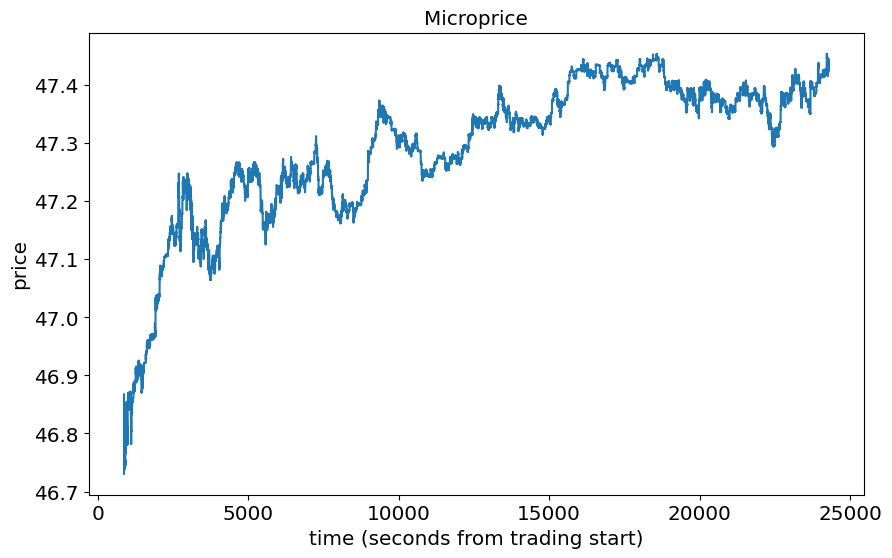

In [23]:
plt.plot(t, microprice)
plt.title('Microprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

plot the difference between micro and mid prices

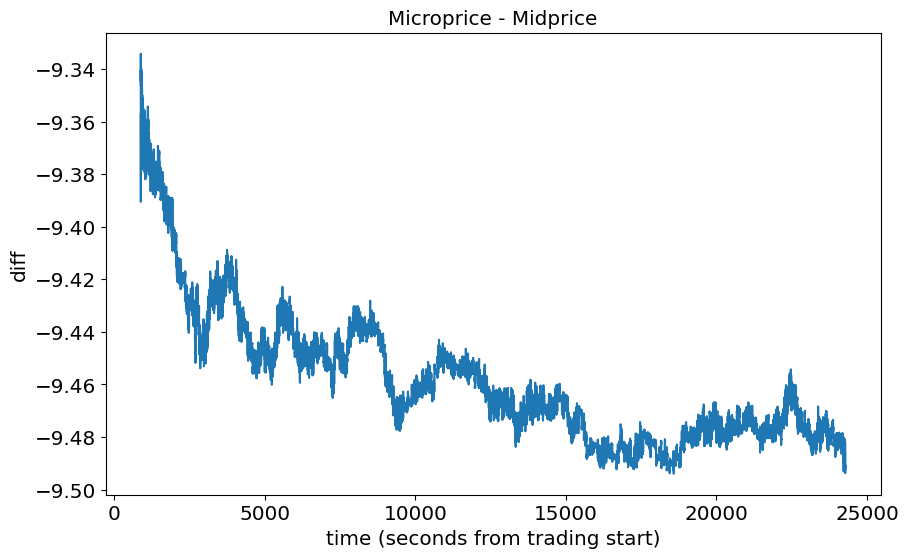

In [24]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

Note that the difference is typically in the range [-0.01, 0.01] while at the beginning of the day it is three times as large.

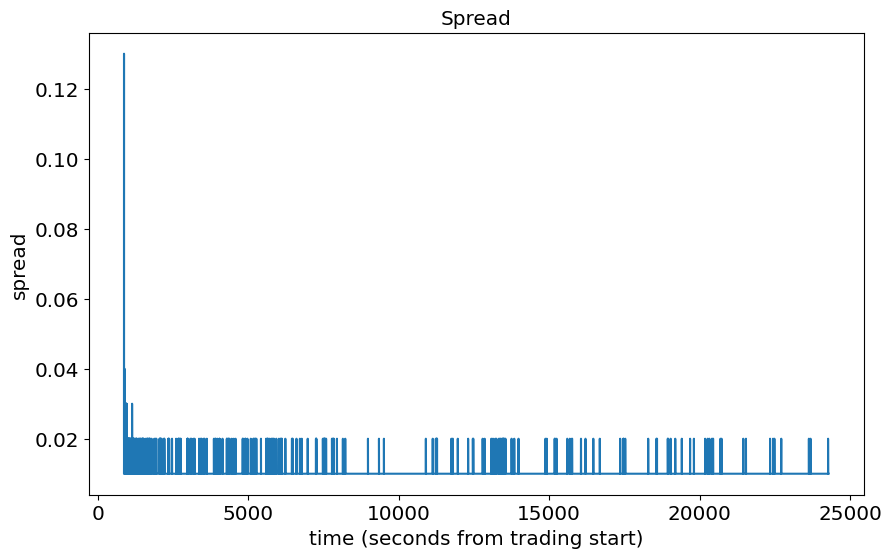

In [25]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.show()

This plot shows that the spread is about 0.13 in the morning, but quickly drops to 0.01 but sometimes spikes to 0.02 (mostly in the morning).

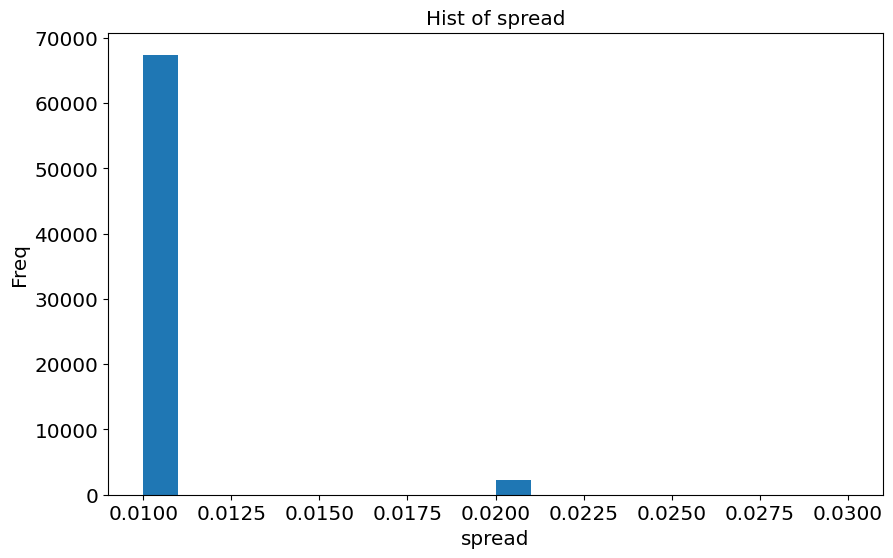

In [26]:
plt.hist(spread,bins=[0.01,0.02,0.03], width=0.001,align='mid') 
plt.title("Hist of spread")
plt.xlabel(r'spread')
plt.ylabel('Freq')
plt.show()

## Volume Imbalance

In [27]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

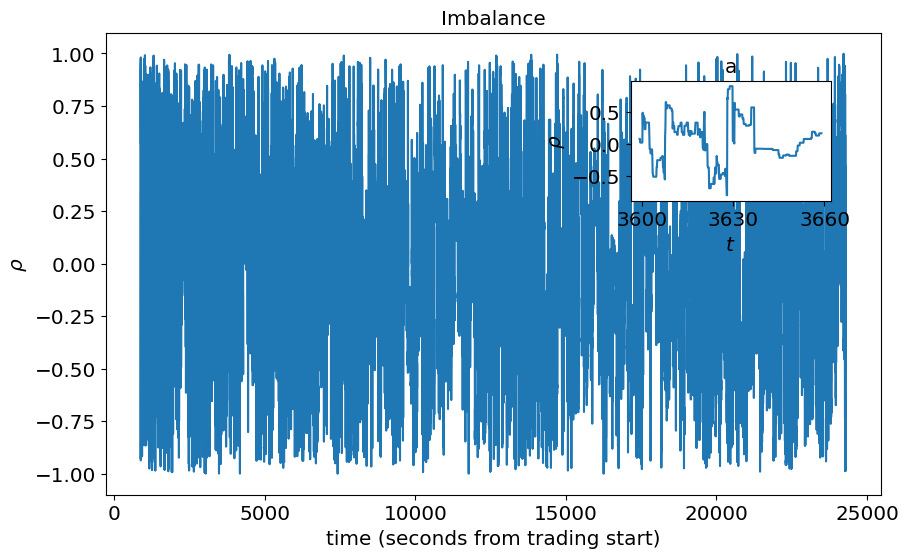

In [28]:
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3599) & (t<=3599+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

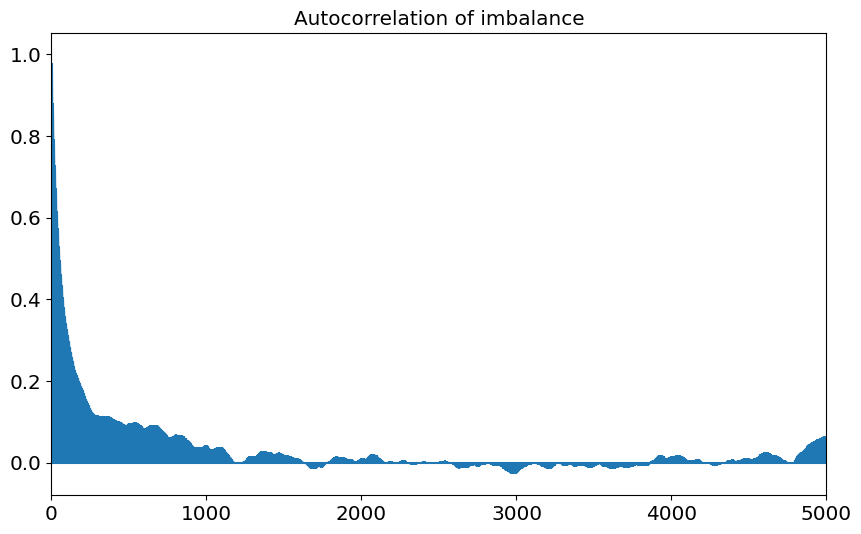

In [29]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,5000])
plt.show()

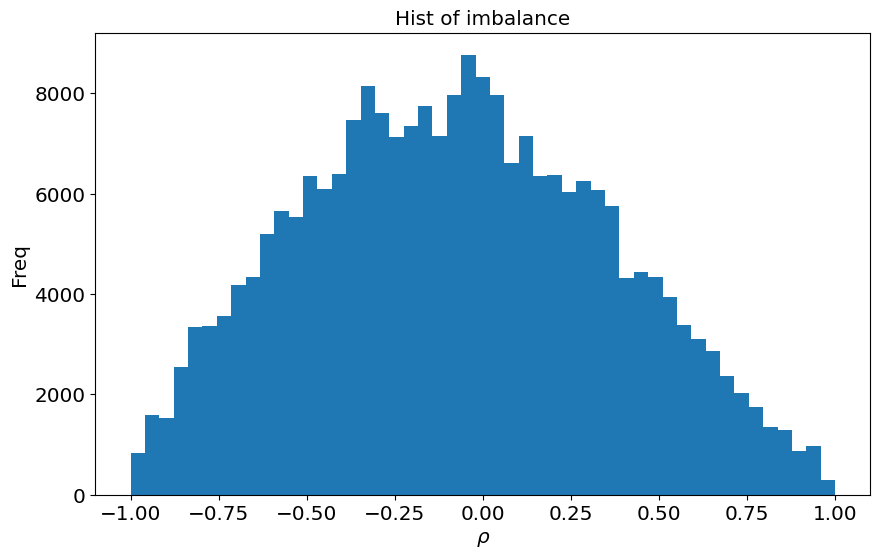

In [30]:
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

# Volume Imbalance at times of Market Orders

In [12]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

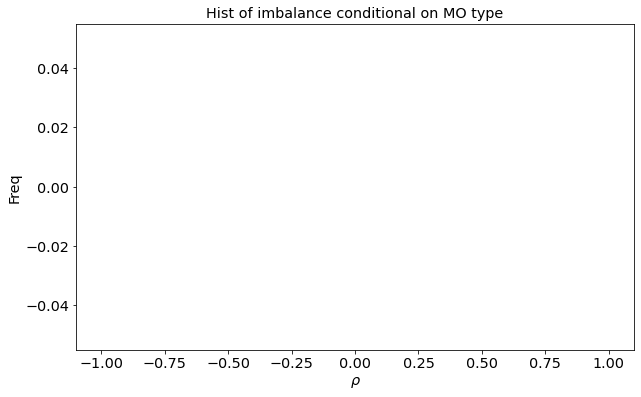

# Liquidation permanent price impact:

In [17]:
import numpy as np
import import_ipynb
import Liquidation_Permanent_Price_Impact_helper as lppi_helpers

importing Jupyter notebook from Liquidation_Permanent_Price_Impact_helper.ipynb


In [18]:
T = 1
Ndt = 6.5 * 3600
dt = T / Ndt
t = np.arange(0, T + dt, dt)

k = 0.006
b = 0.007

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

myphi = np.array([10e-10, 0.001, 0.01, 0.1])
symb = np.array(["o", "*", "+", "^"])

alpha = 100

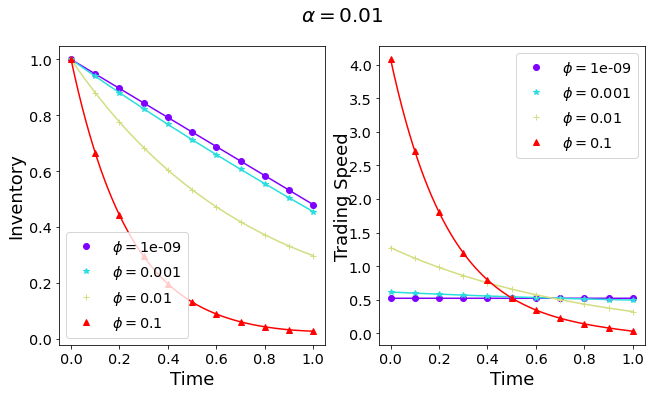

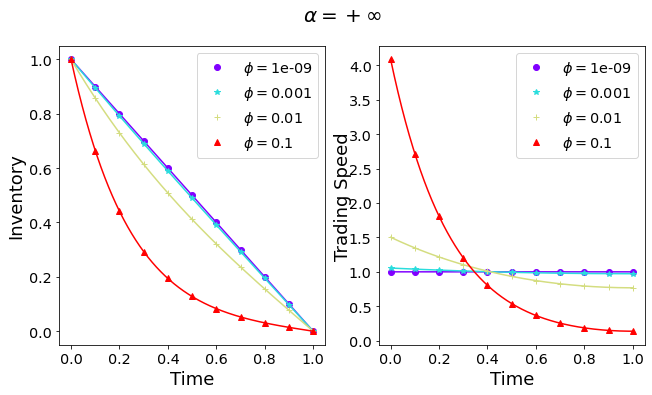

In [19]:
lppi_helpers.plot_inventory_trading_speed(0.01, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.01$")
lppi_helpers.plot_inventory_trading_speed(100, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = +\infty$")

Text(0.5, 1.0, 'Jump Diffusion Process')

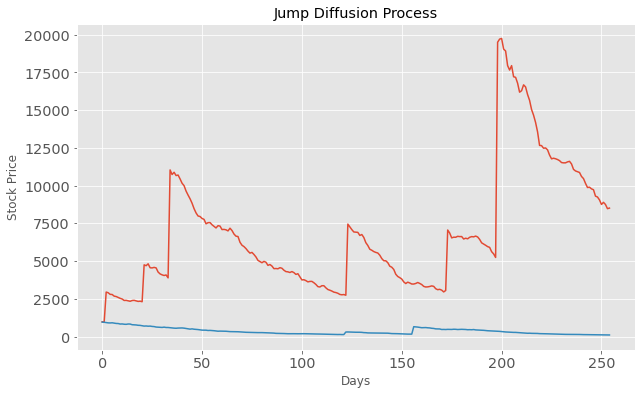

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps, Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson(lam*dt,size=size),
                         np.random.normal(m,v,size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S


S = 1000 # current stock price
T = 1 # time to maturity
r = 0.03 # risk free rate
m = 1 # mean of jump size
v = 0.4 # standard deviation of jump
lam = 4 # intensity of jump i.e. number of jumps per annum
steps = 255 # time steps
Npaths = 2 # number of paths to simulate
sigma = 0.3 # annaul standard deviation , for Wiener process

j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')